<a href="https://colab.research.google.com/github/ani7fx/PlantDiseaseDetection/blob/main/Project_GreenHealth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [ ]:
def convert_image_to_array(image_dir):

    try:

        image = cv2.imread(image_dir)
        scale_percent = 60 # percent of original size
        width = int(image.shape[1] * scale_percent / 100)
        height = int(image.shape[0] * scale_percent / 100)
        dim = (width, height)
        if image is not None:
            image = cv2.resize(image,dim)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

In [ ]:

import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
EPOCHS = 5
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
width=256
height=256
depth=3

In [ ]:
image_list, label_list = [],[]
directory_root = "/content/drive/MyDrive/data2/PlantList/dataset/train"
try:
    print("[INFO] Loading images...")

    root_dir = listdir(directory_root)
    print(root_dir)

    for plant_folder in root_dir[:5]:
        plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}")
        for image in plant_disease_image_list[:500]:


            image_directory = f"{directory_root}/{plant_folder}/{image}"
            print(image_directory)

            image_list.append(convert_image_to_array(image_directory))
            label_list.append(plant_folder)
    print("[INFO] Image loading completed")

except Exception as e:
    print(f"Error: {e}")

[INFO] Loading images...
['Apple___healthy', 'Apple___Apple_scab', 'Apple___Cedar_apple_rust', 'Apple___Black_rot']
/content/drive/MyDrive/data2/PlantList/dataset/train/Apple___healthy/a027ddf2-029c-43c2-b812-f3ffcdefea80___RS_HL 7859_flipTB.JPG
/content/drive/MyDrive/data2/PlantList/dataset/train/Apple___healthy/514b3065-844b-40c8-8a86-043200a1779e___RS_HL 7721.JPG
/content/drive/MyDrive/data2/PlantList/dataset/train/Apple___healthy/89f6b546-2692-4ea9-aaac-66ef1b8a7bdd___RS_HL 7250.JPG
/content/drive/MyDrive/data2/PlantList/dataset/train/Apple___healthy/ad7674f8-ff0c-43f8-9bb7-1c347ba197fe___RS_HL 7812_flipTB.JPG
/content/drive/MyDrive/data2/PlantList/dataset/train/Apple___healthy/622b6e6e-1388-4933-9f74-3ae54937a3d7___RS_HL 5920.JPG
/content/drive/MyDrive/data2/PlantList/dataset/train/Apple___healthy/5e6846df-21b1-444c-ac0d-34c67443dbef___RS_HL 7270.JPG
/content/drive/MyDrive/data2/PlantList/dataset/train/Apple___healthy/c53b358c-9cf4-4388-9743-7c3447715424___RS_HL 7880_flipTB.JPG
/c

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU DEVICE NOT FOUND')
print('Found GPU at:{}'.format(device_name))

Found GPU at:/device:GPU:0


In [ ]:
binarizer = LabelBinarizer()
image_labels = binarizer.fit_transform(label_list)
pickle.dump(binarizer,open('label_transform.pk1','wb'))
n_classes = len(binarizer.classes_)
print(binarizer.classes_)

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy']


In [ ]:
np_image_list = np.array(image_list,dtype = np.float16) / 225.0

In [ ]:
print('[INFO] Splitting data into train, test')
x_train,x_test,y_train,y_test = train_test_split(np_image_list,image_labels,
                                                test_size = 0.2, random_state
                                                =42)

[INFO] Splitting data into train, test


In [ ]:
print(x_train[0].shape)

(153, 153, 3)


In [ ]:
aug = ImageDataGenerator(rotation_range = 25, width_shift_range = 0.1,
                         height_shift_range = 0.1, shear_range = 0.2,
                         zoom_range = 0.2, horizontal_flip = True,
                         fill_mode = "nearest")

In [ ]:
model = Sequential()
inputShape = (153,153,3)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (3,153,153)
    chanDim = 1
model.add(Conv2D(32,(3,3), padding = "valid",input_shape = inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis = chanDim))
model.add(MaxPooling2D(pool_size = (3,3)))
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3), padding = "valid"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis = chanDim))
model.add(Conv2D(64,(3,3), padding = "valid"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis = chanDim))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(3,3), padding = "valid"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis = chanDim))
model.add(Conv2D(128,(3,3), padding = "valid"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis = chanDim))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 151, 151, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 151, 151, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 151, 151, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0

In [ ]:
# distribution
model.compile(optimizer= "adam",loss="binary_crossentropy",metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [ ]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=90, verbose=1
    )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/90
50/50 [==============================] - 63s 224ms/step - loss: 0.7056 - accuracy: 0.6138 - val_loss: 0.7408 - val_accuracy: 0.3900
Epoch 2/90
50/50 [==============================] - 10s 198ms/step - loss: 0.3037 - accuracy: 0.8390 - val_loss: 1.2210 - val_accuracy: 0.2200
Epoch 3/90
50/50 [==============================] - 10s 196ms/step - loss: 0.2137 - accuracy: 0.8713 - val_loss: 2.8116 - val_accuracy: 0.2200
Epoch 4/90
50/50 [==============================] - 10s 195ms/step - loss: 0.1752 - accuracy: 0.9010 - val_loss: 3.9722 - val_accuracy: 0.2200
Epoch 5/90
50/50 [==============================] - 10s 195ms/step - loss: 0.1644 - accuracy: 0.9033 - val_loss: 4.8640 - val_accuracy: 0.2200
Epoch 6/90
50/50 [==============================] - 10s 196ms/step - loss: 0.1430 - accuracy: 0.9109 - val_loss: 3.6963 - val_accuracy: 0.2425
Epoch 7/90
50/50 [==============================] - 10s 195ms/step - loss: 0.1288 - accuracy: 0.9169 - val_loss: 2.8855 - val_accuracy: 0.4725

In [ ]:
from google.colab import files
from IPython.display import Image

In [ ]:
uploaded = files.upload()

Saving 0b37761a-de32-47ee-a3a4-e138b97ef542___JR_FrgE.S 2908_270deg.JPG to 0b37761a-de32-47ee-a3a4-e138b97ef542___JR_FrgE.S 2908_270deg (1).JPG


(1, 153, 153, 3)
[[0. 1. 0. 0.]]
[1]
It is Apple___Black_rot


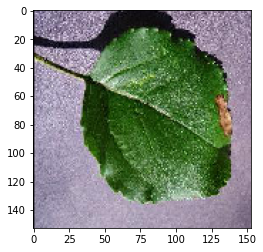

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

image_path= "0b37761a-de32-47ee-a3a4-e138b97ef542___JR_FrgE.S 2908_270deg (1).JPG"
img = image.load_img(image_path, target_size=(153, 153))
plt.imshow(img)
img_array = image.img_to_array(img)

img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction = model.predict(img_preprocessed)
print(img_batch.shape)
print(prediction)
classes = np.argmax(prediction, axis = 1)
print(classes)
if classes[0]==0:
    print("It is Apple___Apple_scab")
elif classes[0]==1:
    print("It is Apple___Black_rot")
elif classes[0] == 2:
    print("It is Apple Cedar rust")
else:
    print("It is healthy")